In [12]:
pip install git+https://github.com/Desklop/Uk_Stemmer

  Cloning https://github.com/Desklop/Uk_Stemmer to /tmp/pip-req-build-760so4g1
  Running command git clone -q https://github.com/Desklop/Uk_Stemmer /tmp/pip-req-build-760so4g1


In [13]:
pip install spark-nlp==3.4.0

     |████████████████████████████████| 140 kB 5.4 MB/s 


In [14]:
pip install pyspark==3.0.2

     |████████████████████████████████| 204.8 MB 55 kB/s 
     |████████████████████████████████| 198 kB 6.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.2-py2.py3-none-any.whl size=205186690 sha256=f7958a8d2c640523a625b656d17f47482600f84932e4deaa3ee44f904fc2ece1
  Stored in directory: /root/.cache/pip/wheels/9a/39/f6/970565f38054a830e9a8593f388b36e14d75dba6c6fdafc1ec
Successfully built pyspark


In [15]:
pip install nlu pyspark==3.0.2

     |████████████████████████████████| 478 kB 5.4 MB/s 
     |████████████████████████████████| 133 kB 39.9 MB/s 
  Attempting uninstall: spark-nlp
    Found existing installation: spark-nlp 3.4.0
    Uninstalling spark-nlp-3.4.0:
      Successfully uninstalled spark-nlp-3.4.0


In [16]:
!pip install pyenchant

     |████████████████████████████████| 55 kB 2.2 MB/s 


In [17]:
!apt-get install libenchant1c2a

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libenchant1c2a is already the newest version (1.6.0-11.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from uk_stemmer import UkStemmer

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp

In [21]:
import nlu

In [138]:
import enchant
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(suppress=True)
nltk.download('stopwords')
nltk.download('punkt')
random_state = 8080

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [25]:
ls

drive/  sample_data/


In [26]:
df = pd.read_csv("/content/drive/MyDrive/full_data.csv")

In [27]:
df.head()

,crm_customer_id,created,NAME_LOWEST
0,50081964,2021-01-25 14:21:07.610,Петлі меблеві
1,50081964,2021-01-25 14:21:07.610,Петлі меблеві
2,50081964,2021-01-29 13:53:52.920,Лотки для столових приборів
3,50081964,2021-05-31 12:21:22.080,Інсектициди
4,50081964,2021-02-20 15:02:06.730,Рейлінги для кухні


In [28]:
df.columns = ["customer_id", "date", "category"]

In [29]:
df.head(2)

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,Петлі меблеві
1,50081964,2021-01-25 14:21:07.610,Петлі меблеві


In [30]:
df.shape

(1412105, 3)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412105 entries, 0 to 1412104
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   customer_id  1412105 non-null  int64 
 1   date         1412105 non-null  object
 2   category     1412105 non-null  object
dtypes: int64(1), object(2)
memory usage: 32.3+ MB


In [32]:
print(f"number of categories: {df.category.nunique()}")

number of categories: 2129


In [33]:
print(f"number of customers: {df.customer_id.nunique()}")

number of customers: 20114


# NLP feature engineering

1. make all words lowercase
2. remove stopwords
3. preform stemming

In [34]:
df.head()

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,Петлі меблеві
1,50081964,2021-01-25 14:21:07.610,Петлі меблеві
2,50081964,2021-01-29 13:53:52.920,Лотки для столових приборів
3,50081964,2021-05-31 12:21:22.080,Інсектициди
4,50081964,2021-02-20 15:02:06.730,Рейлінги для кухні


In [35]:
df.category.unique()[:20]

array(['Петлі меблеві', 'Лотки для столових приборів', 'Інсектициди',
       'Рейлінги для кухні', 'Алюмінієвий профіль', 'Стопори дверні',
       'Зубна паста', 'Куточок алюмінієвий', 'Мішки для сміття',
       'Господарчі рукавички', 'Серветки для прибирання',
       'Аератори для крана', 'Засоби для ванних кімнат', 'Швабри',
       'Засоби для кухні', 'Засоби для догляду за унітазом',
       'Клей побутовий', 'Губки господарчі', 'Пральний порошок',
       'Клей для шпалер'], dtype=object)

In [36]:
ndf = df.drop_duplicates(subset=["customer_id", "category"])

In [37]:
print(f"distinct records: {round((ndf.shape[0] * 100) / df.shape[0])}%")

distinct records: 38%


In [38]:
ndf["category"] = ndf["category"].str.lower()

In [39]:
ndf.head()

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,петлі меблеві
2,50081964,2021-01-29 13:53:52.920,лотки для столових приборів
3,50081964,2021-05-31 12:21:22.080,інсектициди
4,50081964,2021-02-20 15:02:06.730,рейлінги для кухні
6,50081964,2021-02-20 15:02:06.730,алюмінієвий профіль


In [40]:
sum(ndf.category.str.isnumeric())

0

In [41]:
categories = ndf.category.unique()

In [42]:
categories

array(['петлі меблеві', 'лотки для столових приборів', 'інсектициди', ...,
       'насоси для фонтанів', 'композитний профіль', 'дитячі шезлонги'],
      dtype=object)

In [43]:
for category in categories:
    processed_category = [word for word in word_tokenize(category)
                              if (word not in stopwords.words("ukrainian")) and word.isalpha()]
    ndf.loc[ndf["category"] == category, "category"] = ' '.join(processed_category)

In [44]:
ndf.head()

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,петлі меблеві
2,50081964,2021-01-29 13:53:52.920,лотки столових приборів
3,50081964,2021-05-31 12:21:22.080,інсектициди
4,50081964,2021-02-20 15:02:06.730,рейлінги кухні
6,50081964,2021-02-20 15:02:06.730,алюмінієвий профіль


In [45]:
categories

array(['петлі меблеві', 'лотки для столових приборів', 'інсектициди', ...,
       'насоси для фонтанів', 'композитний профіль', 'дитячі шезлонги'],
      dtype=object)

In [46]:
categories = pd.Series(categories)
categories

0                                          петлі меблеві
1                            лотки для столових приборів
2                                            інсектициди
3                                     рейлінги для кухні
4                                    алюмінієвий профіль
                              ...                       
2124                                  домашні кінотеатри
2125    зарядні пристрої та блоки живлення для ноутбуків
2126                                 насоси для фонтанів
2127                                 композитний профіль
2128                                     дитячі шезлонги
Length: 2129, dtype: object

In [47]:
categories.shape

(2129,)

In [48]:
lemma_categories = nlu.load('uk.lemma').predict(categories, output_level='document')

lemma download started this may take some time.
Approximate size to download 2.3 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [49]:
lemma_categories.rename({"document": "category"}, axis=1, inplace=True)

In [50]:
lemma_categories.head()

,category,lem
0,петлі меблеві,"[петля, меблеві]"
1,лотки для столових приборів,"[лотки, для, столовий, приборів]"
2,інсектициди,[інсектициди]
3,рейлінги для кухні,"[рейлінги, для, кухня]"
4,алюмінієвий профіль,"[алюмінієвий, профіль]"


In [51]:
ndf.head()

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,петлі меблеві
2,50081964,2021-01-29 13:53:52.920,лотки столових приборів
3,50081964,2021-05-31 12:21:22.080,інсектициди
4,50081964,2021-02-20 15:02:06.730,рейлінги кухні
6,50081964,2021-02-20 15:02:06.730,алюмінієвий профіль


In [52]:
ndf = ndf.merge(lemma_categories, on="category")

In [53]:
ndf

,customer_id,date,category,lem
0,50081964,2021-01-25 14:21:07.610,петлі меблеві,"[петля, меблеві]"
1,50171691,2021-02-17 13:51:00.350,петлі меблеві,"[петля, меблеві]"
2,1600035308,2021-05-09 14:28:16.517,петлі меблеві,"[петля, меблеві]"
3,2000001033,2020-10-17 14:38:24.470,петлі меблеві,"[петля, меблеві]"
4,2000001042,2021-04-20 19:50:38.070,петлі меблеві,"[петля, меблеві]"
...,...,...,...,...
337538,33000053565,2020-10-31 10:45:18.427,спортивні лави,"[спортивний, лава]"
337539,33000056666,2021-09-15 09:38:11.600,ковані хвіртки,"[кований, хвіртка]"
337540,33000074608,2021-05-09 13:18:15.007,домашні кінотеатри,"[домашній, кінотеатр]"
337541,45002082643,2021-06-29 17:45:13.720,композитний профіль,"[композитний, профіль]"


In [54]:
customers_queries = ndf.set_index(["customer_id", "date"]).drop("category", axis=1)

In [55]:
customers_queries.head()["lem"].tolist()

[['петля', 'меблеві'],
 ['петля', 'меблеві'],
 ['петля', 'меблеві'],
 ['петля', 'меблеві'],
 ['петля', 'меблеві']]

In [56]:
customers_vs_queries = pd.DataFrame(customers_queries["lem"].tolist(), index=ndf.customer_id).stack().reset_index().pivot_table(index="customer_id", columns=0, fill_value=0, aggfunc='size')

In [57]:
customers_vs_queries.head()

,bis,iгрові,lego,аварійний,авто,автоакустика,автодиагностики,автозапчастини,автокрісла,автомагнітоли,автомат,автоматика,автоматичний,автомобіль,автомобільний,автопилососи,автосигналізації,автотермометри,автотехнікс,автофарба,автохолодильники,автошампуні,автошини,агроволокно,адміністративний,аератори,аерозольні,акварельні,аквашузи,акрилові,аксесуари,аксесуарів,активний,акумулятори,акумуляторні,алмазна,алмазного,алмазні,алюмінієвий,анкери,...,шпаклівка,шпалери,шпателі,шпатлівка,штангенциркулі,штани,штемпельна,штора,штроборізи,штукатурка,штукатурні,штучний,шумовіброізоляція,шумівки,шурупи,шуруповерти,щебінь,щит,щоденник,щітки,ягода,яйцерізки,ємність,іграшка,ігровий,ізоляційні,ізоляція,інвентар,інвертори,індексні,індивідуальний,індикатор,іноземний,інсектициди,інсталяції,інструмент,інтерактивні,інформаційний,інфрачервоні,ґрунтовка
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50081964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
50095759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50097247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
50113709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50116694,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
customers_vs_queries[customers_vs_queries > 0] = 1

In [59]:
customers_vs_queries.describe()

,bis,iгрові,lego,аварійний,авто,автоакустика,автодиагностики,автозапчастини,автокрісла,автомагнітоли,автомат,автоматика,автоматичний,автомобіль,автомобільний,автопилососи,автосигналізації,автотермометри,автотехнікс,автофарба,автохолодильники,автошампуні,автошини,агроволокно,адміністративний,аератори,аерозольні,акварельні,аквашузи,акрилові,аксесуари,аксесуарів,активний,акумулятори,акумуляторні,алмазна,алмазного,алмазні,алюмінієвий,анкери,...,шпаклівка,шпалери,шпателі,шпатлівка,штангенциркулі,штани,штемпельна,штора,штроборізи,штукатурка,штукатурні,штучний,шумовіброізоляція,шумівки,шурупи,шуруповерти,щебінь,щит,щоденник,щітки,ягода,яйцерізки,ємність,іграшка,ігровий,ізоляційні,ізоляція,інвентар,інвертори,індексні,індивідуальний,індикатор,іноземний,інсектициди,інсталяції,інструмент,інтерактивні,інформаційний,інфрачервоні,ґрунтовка
count,"20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00",...,"20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00"
mean,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.02,0.22,0.00,0.00,0.00,0.00,0.03,0.00,0.03,0.01,0.03,0.03,0.00,0.08,0.00,0.00,0.01,0.02,0.00,0.02,0.02,0.01,0.00,0.00,0.03,0.02,0.05,...,0.08,0.12,0.11,0.01,0.00,0.00,0.00,0.08,0.00,0.05,0.03,0.03,0.02,0.01,0.14,0.01,0.00,0.00,0.03,0.05,0.00,0.00,0.06,0.02,0.08,0.09,0.02,0.01,0.00,0.01,0.00,0.00,0.00,0.03,0.00,0.03,0.01,0.00,0.00,0.11
std,0.04,0.01,0.12,0.11,0.06,0.02,0.01,0.01,0.06,0.01,0.04,0.03,0.18,0.15,0.42,0.04,0.01,0.02,0.01,0.17,0.02,0.16,0.12,0.17,0.17,0.03,0.27,0.07,0.02,0.08,0.16,0.01,0.12,0.15,0.07,0.03,0.01,0.18,0.15,0.21,...,0.27,0.32,0.32,0.09,0.06,0.04,0.04,0.28,0.01,0.21,0.17,0.17,0.15,0.09,0.34,0.12,0.06,0.06,0.17,0.23,0.06,0.06,0.24,0.13,0.27,0.29,0.15,0.08,0.05,0.09,0.02,0.02,0.01,0.16,0.05,0.17,0.09,0.01,0.06,0.32
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [53]:
customers_vs_queries.to_csv("/content/drive/MyDrive/customers_vs_queries.csv")

In [60]:
docs = list(pd.Series(ndf.lem.astype(str).unique()).apply(lambda x: x[1:-1].replace("'", "").split(', ')).values)

In [61]:
dictionary = Dictionary(docs)

In [62]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [63]:
corpus[:10]

[[(0, 1), (1, 1)],
 [(2, 1)],
 [(3, 1), (4, 1)],
 [(5, 1), (6, 1)],
 [(7, 1), (8, 1)],
 [(3, 1), (9, 1)],
 [(10, 1), (11, 1)],
 [(12, 1)],
 [(13, 1), (14, 1)],
 [(10, 1), (15, 1)]]

In [64]:
tfidf = TfidfModel(corpus)

In [65]:
[corpora for corpora in corpus]

[[(0, 1), (1, 1)],
 [(2, 1)],
 [(3, 1), (4, 1)],
 [(5, 1), (6, 1)],
 [(7, 1), (8, 1)],
 [(3, 1), (9, 1)],
 [(10, 1), (11, 1)],
 [(12, 1)],
 [(13, 1), (14, 1)],
 [(10, 1), (15, 1)],
 [(16, 1), (17, 1)],
 [(5, 1), (18, 1)],
 [(19, 1)],
 [(20, 1), (21, 1), (22, 1)],
 [(23, 1)],
 [(24, 1)],
 [(25, 1), (26, 1)],
 [(27, 1)],
 [(28, 1)],
 [(29, 1)],
 [(30, 1)],
 [(31, 1)],
 [(32, 1)],
 [(33, 1), (34, 1)],
 [(35, 1), (36, 1), (37, 1)],
 [(38, 1), (39, 1)],
 [(34, 1)],
 [(40, 1), (41, 1)],
 [(42, 1)],
 [(20, 1), (43, 1), (44, 1), (45, 1)],
 [(46, 1)],
 [(47, 1), (48, 1)],
 [(49, 1), (50, 1), (51, 1)],
 [(52, 1)],
 [(53, 1)],
 [(54, 1)],
 [(9, 1), (55, 1)],
 [(56, 1), (57, 1)],
 [(47, 1), (58, 1)],
 [(59, 1), (60, 1), (61, 1)],
 [(62, 1), (63, 1)],
 [(64, 1)],
 [(65, 1)],
 [(66, 1), (67, 1)],
 [(68, 1)],
 [(69, 1)],
 [(70, 1)],
 [(71, 1), (72, 1)],
 [(73, 1), (74, 1)],
 [(75, 1), (76, 1)],
 [(77, 1)],
 [(78, 1)],
 [(79, 1), (80, 1)],
 [(81, 1)],
 [(82, 1), (83, 1)],
 [(84, 1)],
 [(85, 1), (86, 1

In [109]:
tfidf_weights = pd.DataFrame(tfidf[corpus[0]])
for corpora in corpus:
  tfidf_weights = tfidf_weights.append(pd.DataFrame(tfidf[corpora]), ignore_index=True) 

tfidf_weights

,0,1
0,0,0.64
1,1,0.77
2,0,0.64
3,1,0.77
4,2,1.00
...,...,...
2100,1267,0.80
2101,4,0.65
2102,1268,0.76
2103,118,0.33


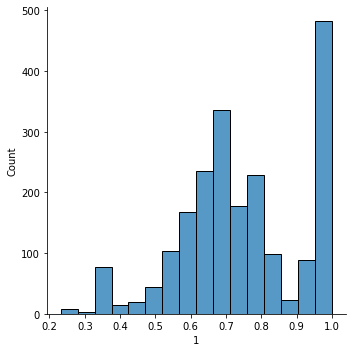

In [110]:
sns.displot(tfidf_weights.iloc[:, 1]);

In [111]:
(tfidf_weights.iloc[:, 1] < 1).value_counts()

True     1623
False     482
Name: 1, dtype: int64

In [112]:
tfidf[corpus[10]]

[(16, 0.6701241729302072), (17, 0.7422490100058105)]

In [113]:
corpus[4]

[(7, 1), (8, 1)]

In [114]:
print(dictionary[7], dictionary[8])

зубний паста


In [115]:
tfidf_weights.rename({0: "id", 1: "weight"}, axis=1, inplace=True)

In [116]:
tfidf_weights.head()

,id,weight
0,0,0.64
1,1,0.77
2,0,0.64
3,1,0.77
4,2,1.00


In [117]:
tfidf_weights = tfidf_weights.groupby("id").agg({"weight": ["max", "min", "mean"]}).reset_index()

In [118]:
tfidf_weights.head()

id weight          
        max  min mean
0  0   0.68 0.60 0.62
1  1   0.79 0.77 0.78
2  2   1.00 1.00 1.00
3  3   0.76 0.68 0.70
4  4   0.74 0.65 0.68

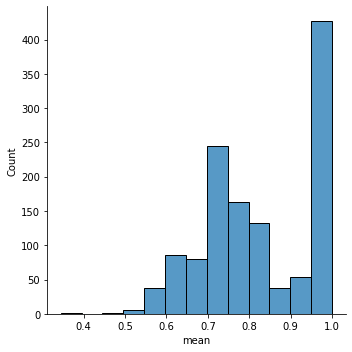

In [119]:
sns.displot(tfidf_weights["weight"]["mean"]);

In [120]:
tfidf_weights["id"] = tfidf_weights["id"].apply(lambda x: dictionary[x])

In [122]:
tfidf_weights.head()

id weight          
                  max  min mean
0      меблеві   0.68 0.60 0.62
1        петля   0.79 0.77 0.78
2  інсектициди   1.00 1.00 1.00
3  алюмінієвий   0.76 0.68 0.70
4      профіль   0.74 0.65 0.68

In [135]:
for category, weight in zip(tfidf_weights["id"], tfidf_weights["weight"]["mean"]):
  customers_vs_queries.loc[:, category] = (customers_vs_queries.loc[:, category] * weight)

In [137]:
customers_vs_queries.head()

,bis,iгрові,lego,аварійний,авто,автоакустика,автодиагностики,автозапчастини,автокрісла,автомагнітоли,автомат,автоматика,автоматичний,автомобіль,автомобільний,автопилососи,автосигналізації,автотермометри,автотехнікс,автофарба,автохолодильники,автошампуні,автошини,агроволокно,адміністративний,аератори,аерозольні,акварельні,аквашузи,акрилові,аксесуари,аксесуарів,активний,акумулятори,акумуляторні,алмазна,алмазного,алмазні,алюмінієвий,анкери,...,шпаклівка,шпалери,шпателі,шпатлівка,штангенциркулі,штани,штемпельна,штора,штроборізи,штукатурка,штукатурні,штучний,шумовіброізоляція,шумівки,шурупи,шуруповерти,щебінь,щит,щоденник,щітки,ягода,яйцерізки,ємність,іграшка,ігровий,ізоляційні,ізоляція,інвентар,інвертори,індексні,індивідуальний,індикатор,іноземний,інсектициди,інсталяції,інструмент,інтерактивні,інформаційний,інфрачервоні,ґрунтовка
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50081964,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50095759,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50097247,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.93
50113709,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50116694,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [139]:
user_to_user_sim_matrix = pd.DataFrame(
    cosine_similarity(customers_vs_queries),
    index=customers_vs_queries.index,
    columns=customers_vs_queries.index
)

In [141]:
user_to_user_sim_matrix.head()

customer_id,50081964,50095759,50097247,50113709,50116694,50124346,50163389,50168245,50170083,50171691,50176842,50185742,800049993,800050418,800059359,1120154902,1120155204,1200032730,1200033892,1200034069,1200037122,1200042504,1200048313,1200048318,1200052047,1200053955,1200054648,1200084141,1200092862,1600035308,1600086288,1700046296,1700058131,1700061013,2000001015,2000001023,2000001033,2000001042,2000001056,2000001057,...,85100263106,85100264782,85100268956,85100269632,85100271369,85100271538,85100272974,85100273081,85100276796,85100276802,85100277631,85100279283,85100281367,85100281710,85100282133,85100282466,85100283851,85100284878,85100286893,85100287444,85100288668,85100291905,85100292323,85100292427,85100292492,85100314905,85100315599,85100316264,85100316381,85100317816,85100320089,85100321783,85100322432,85100323252,85100325531,85100327278,85100328957,85100329243,85100329312,85100330032
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50081964,1.00,0.05,0.00,0.04,0.00,0.00,0.10,0.00,0.12,0.27,0.08,0.00,0.00,0.00,0.06,0.07,0.15,0.00,0.13,0.05,0.00,0.09,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.21,0.00,0.00,0.07,0.05,0.10,0.17,0.15,0.00,...,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.10,0.06,0.04,0.00,0.03,0.06,0.00,0.00,0.07,0.00,0.16,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.05,0.00,0.00,0.06,0.16,0.00,0.00,0.00,0.22,0.00,0.00
50095759,0.05,1.00,0.00,0.02,0.12,0.03,0.07,0.00,0.36,0.20,0.08,0.14,0.10,0.00,0.09,0.08,0.04,0.00,0.09,0.14,0.00,0.20,0.00,0.00,0.10,0.11,0.07,0.00,0.00,0.17,0.00,0.16,0.10,0.08,0.08,0.18,0.23,0.13,0.11,0.07,...,0.00,0.12,0.00,0.00,0.00,0.13,0.00,0.10,0.00,0.06,0.24,0.02,0.00,0.00,0.00,0.05,0.14,0.00,0.06,0.00,0.00,0.12,0.24,0.08,0.10,0.06,0.16,0.00,0.00,0.03,0.13,0.12,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.00
50097247,0.00,0.00,1.00,0.08,0.00,0.11,0.17,0.00,0.03,0.00,0.06,0.02,0.00,0.00,0.14,0.00,0.25,0.00,0.05,0.00,0.00,0.13,0.12,0.00,0.19,0.03,0.14,0.00,0.17,0.10,0.00,0.00,0.07,0.14,0.25,0.04,0.14,0.32,0.13,0.17,...,0.11,0.18,0.00,0.16,0.00,0.32,0.11,0.07,0.00,0.00,0.21,0.11,0.13,0.07,0.22,0.00,0.02,0.00,0.10,0.04,0.00,0.10,0.12,0.14,0.03,0.10,0.08,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.11,0.12,0.06,0.00,0.20,0.00
50113709,0.04,0.02,0.08,1.00,0.16,0.20,0.11,0.00,0.00,0.11,0.22,0.05,0.11,0.00,0.05,0.00,0.09,0.10,0.00,0.07,0.19,0.08,0.00,0.09,0.16,0.23,0.04,0.22,0.12,0.14,0.00,0.03,0.17,0.11,0.04,0.13,0.22,0.15,0.08,0.00,...,0.08,0.12,0.00,0.00,0.00,0.03,0.15,0.25,0.08,0.28,0.08,0.05,0.07,0.04,0.00,0.08,0.11,0.09,0.14,0.03,0.00,0.19,0.00,0.05,0.06,0.24,0.02,0.12,0.00,0.08,0.02,0.00,0.00,0.24,0.00,0.14,0.18,0.00,0.12,0.09
50116694,0.00,0.12,0.00,0.16,1.00,0.15,0.10,0.00,0.11,0.24,0.06,0.06,0.03,0.00,0.17,0.21,0.18,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.13,0.12,0.18,0.19,0.18,0.14,0.00,0.00,0.00,0.21,0.12,0.03,0.15,0.08,0.14,0.00,...,0.00,0.19,0.00,0.05,0.00,0.02,0.11,0.07,0.00,0.14,0.00,0.06,0.11,0.00,0.17,0.14,0.00,0.14,0.14,0.00,0.00,0.09,0.00,0.00,0.12,0.15,0.23,0.20,0.00,0.11,0.04,0.06,0.00,0.08,0.00,0.20,0.09,0.00,0.03,0.19


In [143]:
user_to_user_sim_matrix.iloc[0].sort_values(ascending=False)

customer_id
50081964      1.00
33000030393   0.44
45002172157   0.43
19000031041   0.43
2000010608    0.42
              ... 
19000107828   0.00
19000107793   0.00
19000107747   0.00
19000107745   0.00
19000074125   0.00
Name: 50081964, Length: 20066, dtype: float64

In [145]:
df[df["customer_id"] == 33000030393]["category"]

1129591    Кулери для води
1129592     Стопори дверні
1129593    Кулери для води
1129594    Кулери для води
Name: category, dtype: object

In [146]:
df[df["customer_id"] == 50081964]["category"]

0                   Петлі меблеві
1                   Петлі меблеві
2     Лотки для столових приборів
3                     Інсектициди
4              Рейлінги для кухні
5              Рейлінги для кухні
6             Алюмінієвий профіль
7             Алюмінієвий профіль
8                  Стопори дверні
9                     Інсектициди
10                    Зубна паста
11                    Зубна паста
12            Куточок алюмінієвий
13            Куточок алюмінієвий
Name: category, dtype: object

In [147]:
df[df["customer_id"] == 45002172157]["category"]


1366328    Господарчі мила для прання
1366329         З'єднувачі для шланга
1366330            Насіння для газону
1366331            Тоніки та лосьйони
1366332                   Зубна паста
1366333     Перев'язувальний матеріал
1366334             Фарба для волосся
1366335     Перев'язувальний матеріал
1366336         З'єднувачі для шланга
1366337            Тоніки та лосьйони
1366338         З'єднувачі для шланга
1366339             Ножівки по дереву
1366340                   Зубна паста
1366341             Ножівки по дереву
Name: category, dtype: object